In [ ]:
# default_exp callback.core

# Callback

> Miscellaneous callbacks for timeseriesAI.

In [ ]:
#export 
from tsai.imports import *
from tsai.utils import *
from tsai.data.preprocessing import *
from tsai.data.transforms import *
from tsai.models.layers import *
from fastai.callback.all import *

In [ ]:
#export
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

## Events

A callback can implement actions on the following events:
* before_fit: called before doing anything, ideal for initial setup.
* before_epoch: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
* before_train: called at the beginning of the training part of an epoch.
* before_batch: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
* after_pred: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
* after_loss: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
* before_backward: called after the loss has been computed, but only in training mode (i.e. when the backward pass will be used)
* after_backward: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
* after_step: called after the step and before the gradients are zeroed.
* after_batch: called at the end of a batch, for any clean-up before the next one.
* after_train: called at the end of the training phase of an epoch.
* before_validate: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
* after_validate: called at the end of the validation part of an epoch.
* after_epoch: called at the end of an epoch, for any clean-up before the next one.
* after_fit: called at the end of training, for final clean-up.

## Learner attributes

When writing a callback, the following attributes of Learner are available:

* **model**: the model used for training/validation
* **data**: the underlying DataLoaders
* **loss_func**: the loss function used
* **opt**: the optimizer used to udpate the model parameters
* **opt_func**: the function used to create the optimizer
* **cbs**: the list containing all Callbacks
* **dl**: current DataLoader used for iteration
* **x/xb**: last input drawn from self.dl (potentially modified by callbacks). xb is always a tuple (potentially with one element) and x is detuplified. You can only assign to xb.
* **y/yb**: last target drawn from self.dl (potentially modified by callbacks). yb is always a tuple (potentially with one element) and y is detuplified. You can only assign to yb.
* **pred**: last predictions from self.model (potentially modified by callbacks)
* **loss**: last computed loss (potentially modified by callbacks)
* **n_epoch**: the number of epochs in this training
* **n_iter**: the number of iterations in the current self.dl
* **epoch**: the current epoch index (from 0 to n_epoch-1)
* **iter**: the current iteration index in self.dl (from 0 to n_iter-1)

The following attributes are added by TrainEvalCallback and should be available unless you went out of your way to remove that callback:
* **train_iter**: the number of training iterations done since the beginning of this training
* **pct_train**: from 0. to 1., the percentage of training iterations completed
* **training**: flag to indicate if we're in training mode or not

The following attribute is added by Recorder and should be available unless you went out of your way to remove that callback:
* **smooth_loss**: an exponentially-averaged version of the training loss

## Gambler's loss: noisy labels

In [ ]:
#export
class GamblersCallback(Callback):
    "A callback to use metrics with gambler's loss"
    def after_loss(self): self.learn.pred = self.learn.pred[..., :-1]
        

def gambler_loss(reward=2):
    def _gambler_loss(model_output, targets):
        outputs = torch.nn.functional.softmax(model_output, dim=1)
        outputs, reservation = outputs[:, :-1], outputs[:, -1]
        gain = torch.gather(outputs, dim=1, index=targets.unsqueeze(1)).squeeze()
        doubling_rate = (gain + reservation / reward).log()
        return - doubling_rate.mean()
    return 

In [ ]:
from tsai.data.all import *
from tsai.models.InceptionTime import *
from tsai.models.layers import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
loss_func = gambler_loss()
learn = Learner(dls, InceptionTime(dls.vars, dls.c + 1), loss_func=loss_func, cbs=GamblersCallback, metrics=[accuracy])
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.883440,1.907427,0.166667,00:04


## Transform scheduler

In [ ]:
# export
class TransformScheduler(Callback):
    "A callback to schedule batch transforms during training based on a function (sched_lin, sched_exp, sched_cos (default), etc)"
    def __init__(self, schedule_func:callable, show_plot:bool=False): 
        self.schedule_func,self.show_plot = schedule_func,show_plot
        self.mult = []

    def before_fit(self):
        for pct in np.linspace(0, 1, len(self.dls.train) * self.n_epoch): self.mult.append(self.schedule_func(pct))
        # get initial magnitude values and update initial value
        self.mag = []
        self.mag_tfms = []
        for t in self.dls.after_batch: 
            if hasattr(t, 'magnitude'):
                self.mag.append(t.magnitude)
                t.magnitude *= self.mult[0]
                self.mag_tfms.append(t)

    def after_batch(self):
        if self.training and len(self.mag_tfms)>0 and self.train_iter < len(self.mult):
            # set values for next batch
            for t,m in zip(self.mag_tfms, self.mag): 
                t.magnitude = m * self.mult[self.train_iter]
                
    def after_fit(self):
        if self.show_plot and self.mult != [] and len(self.mag_tfms)>0: 
            print()
            plt.plot(self.mult)
            plt.title('Scheduled tfms')
            plt.show()
            print()
            self.show_plot = False
        # set values to initial values
        for t,m in zip(self.mag_tfms, self.mag): t.magnitude = m
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.schedule_func})'

In [ ]:
TransformScheduler(SchedCos(1, 0))

TransformScheduler(<fastai.callback.schedule._Annealer object at 0x7fc1b8e01fd0>)

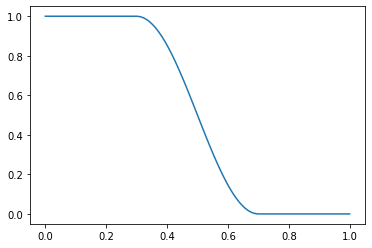

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.4, 0.3], [SchedLin(1.,1.), SchedCos(1.,0.), SchedLin(0.,.0), ])
plt.plot(p, [f(o) for o in p]);

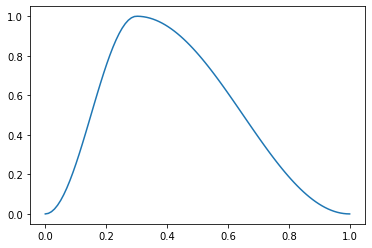

In [ ]:
p = torch.linspace(0.,1,100)
f = combine_scheds([0.3, 0.7], [SchedCos(0.,1.), SchedCos(1.,0.)])
plt.plot(p, [f(o) for o in p]);

## ShowGraph

In [ ]:
#export
class ShowGraph(Callback):
    "(Modified) Update a graph of training and validation loss"
    order,run_valid=65,False
    names = ['train', 'valid']
    def __init__(self, plot_metrics:bool=True, final_losses:bool=True):
        store_attr("plot_metrics,final_losses")

    def before_fit(self):
        self.run = not hasattr(self.learn, 'lr_finder') and not hasattr(self, "gather_preds")
        if not(self.run): return
        self.nb_batches = []
        self.learn.recorder.loss_idxs = [i for i,n in enumerate(self.learn.recorder.metric_names[1:-1]) if 'loss' in n]
        _metrics_info = [(i,n) for i,n in enumerate(self.learn.recorder.metric_names[1:-1]) if 'loss' not in n]
        if len(_metrics_info) > 0: 
            self.metrics_idxs, self.metrics_names = list(zip(*_metrics_info))
        else: 
            self.metrics_idxs, self.metrics_names = None, None

    def after_train(self): self.nb_batches.append(self.train_iter - 1)

    def after_epoch(self):
        "Plot validation loss in the pbar graph"
        if not self.nb_batches: return
        rec = self.learn.recorder
        if self.epoch == 0:
            self.rec_start = len(rec.losses)
        iters = range_of(rec.losses)
        val_losses = np.stack(rec.values)[:, self.learn.recorder.loss_idxs[-1]].tolist()
        x_bounds = (0, len(rec.losses) - 1)
        if self.epoch == 0:
            y_min = min((min(rec.losses), min(val_losses)))
            y_max = max((max(rec.losses), max(val_losses)))
        else:
            y_min = min((min(rec.losses[self.rec_start-1:]), min(val_losses)))
            y_max = max((max(rec.losses[self.rec_start-1:]), max(val_losses)))
        margin = (y_max - y_min) * .05
        y_bounds = (y_min - margin, y_max + margin)
        self.update_graph([(iters, rec.losses), (self.nb_batches, val_losses)], x_bounds, y_bounds)

    def after_fit(self):
        plt.close(self.graph_ax.figure)
        if self.plot_metrics: self.learn.plot_metrics(final_losses=self.final_losses)

    def update_graph(self, graphs, x_bounds=None, y_bounds=None, figsize=(6,4)):
        if not hasattr(self, 'graph_fig'):
            self.graph_fig, self.graph_ax = plt.subplots(1, figsize=figsize)
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        self.graph_ax.clear()
        if len(self.names) < len(graphs): self.names += [''] * (len(graphs) - len(self.names))
        for g,n in zip(graphs,self.names): 
            self.graph_ax.plot(*g, label=n)
        self.graph_ax.legend(loc='upper right')
        self.graph_ax.grid(color='gainsboro', linewidth=.5)
        if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)
        if y_bounds is not None: self.graph_ax.set_ylim(*y_bounds)
        self.graph_ax.set_title(f'Losses\nepoch: {self.epoch +1}/{self.n_epoch}')
        self.graph_out.update(self.graph_ax.figure)
        
ShowGraphCallback2 = ShowGraph

## SaveModel

In [ ]:
#export

class SaveModel(TrackerCallback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end with a verbose option."
    _only_train_loop,order = True,TrackerCallback.order+1
    def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, at_end=False,
                 with_opt=False, reset_on_fit=True, verbose=False):
        super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, reset_on_fit=reset_on_fit)
        assert not (every_epoch and at_end), "every_epoch and at_end cannot both be set to True"
        # keep track of file path for loggers
        self.last_saved_path = None
        store_attr('fname,every_epoch,at_end,with_opt,verbose')

    def _save(self, name): self.last_saved_path = self.learn.save(name, with_opt=self.with_opt)

    def after_epoch(self):
        "Compare the value monitored to its best score and save if best."
        if self.every_epoch:
            if (self.epoch%self.every_epoch) == 0: self._save(f'{self.fname}_{self.epoch}')
        else: #every improvement
            super().after_epoch()
            if self.new_best:
                pv(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.', self.verbose)
                self._save(f'{self.fname}')

    def after_fit(self, **kwargs):
        "Load the best model."
        if self.at_end: self._save(f'{self.fname}')
        elif not self.every_epoch: self.learn.load(f'{self.fname}', with_opt=self.with_opt)

## Uncertainty-based data augmentation

In [ ]:
#export
class UBDAug(Callback):
    r"""A callback to implement the uncertainty-based data augmentation."""
    
    def __init__(self, batch_tfms:list, N:int=2, C:int=4, S:int=1): 
        r'''
        Args:
            batch_tfms:   list of available transforms applied to the combined batch. They will be applied in addition to the dl tfms.
            N:            # composition steps (# transforms randomly applied to each sample)
            C:            # augmented data per input data (# times N transforms are applied)
            S:            # selected data points used for training (# augmented samples in the final batch from each original sample)
        '''
        
        self.C, self.S = C, min(S, C)
        self.batch_tfms = L(batch_tfms)
        self.n_tfms = len(self.batch_tfms)
        self.N = min(N, self.n_tfms)
        
    def before_fit(self):
        assert hasattr(self.loss_func, 'reduction'), "You need to pass a loss_function with a 'reduction' attribute"
        self.red = self.loss_func.reduction
    
    def before_batch(self):
        if self.training:
            with torch.no_grad():
                setattr(self.loss_func, 'reduction', 'none')
                for i in range(self.C):
                    idxs = np.random.choice(self.n_tfms, self.N, False)
                    x_tfm = compose_tfms(self.x, self.batch_tfms[idxs], split_idx=0)
                    loss = self.loss_func(self.learn.model(x_tfm), self.y).reshape(-1,1)
                    if i == 0:
                        x2 = x_tfm.unsqueeze(1)
                        max_loss = loss
                    else: 
                        losses = torch.cat((max_loss, loss), dim=1)
                        x2 = torch.cat((x2, x_tfm.unsqueeze(1)), dim=1)
                        x2 = x2[np.arange(x2.shape[0]).reshape(-1,1), losses.argsort(1)[:, -self.S:]]
                        max_loss = losses.max(1)[0].reshape(-1,1)
                setattr(self.loss_func, 'reduction', self.red)
            x2 = x2.reshape(-1, self.x.shape[-2], self.x.shape[-1])
            if self.S > 1: self.learn.yb = (torch_tile(self.y, 2),)
            self.learn.xb = (x2,)

    def __repr__(self): return f'UBDAug({[get_tfm_name(t) for t in self.batch_tfms]})'

In [ ]:
from tsai.data.all import *
from tsai.models.all import *
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, batch_tfms=[TSStandardize()])
model = create_model(InceptionTime, dls=dls)
TS_tfms = [TSMagScale(.75, p=.5), TSMagWarp(.1, p=0.5),  TSWindowWarp(.25, p=.5), 
           TSSmooth(p=0.5), TSRandomResizedCrop(.1, p=.5), 
           TSRandomCropPad(.3, p=0.5), 
           TSMagAddNoise(.5, p=.5)]

ubda_cb = UBDAug(TS_tfms, N=2, C=4, S=2)
learn = Learner(dls, model, cbs=ubda_cb, metrics=accuracy)
learn.fit_one_cycle(1)

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


epoch,train_loss,valid_loss,accuracy,time
0,1.862016,1.742493,0.288889,00:11


# Weight per sample loss

This process shows an example of how the weights could be calculated. This particular regression method was published in: 

Yang, Y., Zha, K., Chen, Y. C., Wang, H., & Katabi, D. (2021). Delving into Deep Imbalanced Regression. arXiv preprint arXiv:2102.09554.    
(https://arxiv.org/pdf/2102.09554.pdf)

In [ ]:
# export
from scipy.ndimage import gaussian_filter1d
from scipy.signal.windows import triang
from scipy.ndimage import convolve1d


def get_lds_kernel_window(lds_kernel="gaussian", lds_ks=9, lds_sigma=1):
    r"""Function to determine the label distribution smoothing kernel window

    lds_kernel (str): LDS kernel type
    lds_ks (int): LDS kernel size (should be an odd number).
    lds_sigma (float): LDS gaussian/laplace kernel sigma
    """

    assert lds_kernel in ['gaussian', 'triang', 'laplace']
    half_ks = (lds_ks - 1) // 2

    if lds_kernel == 'gaussian':
        base_kernel = [0.] * half_ks + [1.] + [0.] * half_ks
        kernel_window = gaussian_filter1d(
            base_kernel, sigma=lds_sigma) / max(gaussian_filter1d(base_kernel, sigma=lds_sigma))
    elif lds_kernel == 'triang':
        kernel_window = triang(lds_ks)
    else:
        def laplace(x): return np.exp(-abs(x) / lds_sigma) / (2. * lds_sigma)
        kernel_window = list(map(laplace, np.arange(-half_ks, half_ks + 1))) / \
            max(map(laplace, np.arange(-half_ks, half_ks + 1)))

    return kernel_window


def prepare_LDS_weights(labels, n_bins=None, label_range=None, reweight='inv', lds_kernel='gaussian', lds_ks=9, lds_sigma=1, 
                        max_rel_weight=None, show_plot=True):
    
    assert reweight in {'inv', 'sqrt_inv'}
    labels_shape = labels.shape
    if n_bins is None:
        labels = labels.astype(int)
        n_bins = np.max(labels) - np.min(labels)
    num_per_label, bin_edges = np.histogram(labels, bins=n_bins, range=label_range)
    new_labels = np.searchsorted(bin_edges, labels, side='left')
    new_labels[new_labels == 0] = 1
    if reweight == 'sqrt_inv':
        num_per_label = np.sqrt(num_per_label)
    lds_kernel_window = get_lds_kernel_window(lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
    smoothed_value = convolve1d(num_per_label, weights=lds_kernel_window, mode='constant')
    if show_plot:
        plt.bar(bin_edges[:-1], num_per_label / num_per_label.sum(), width=(bin_edges[1]-bin_edges[0]), color='lime', edgecolor='black', label='original')
        plt.plot(bin_edges[:-1], smoothed_value / smoothed_value.sum(), color='red', label='smoothed')
        plt.title(f"Label distribution by bin (reweight={reweight})")
        plt.legend(loc='best')
        plt.show()
    num_per_label = smoothed_value[new_labels.flatten() - 1].reshape(*labels_shape)
    weights = 1 / num_per_label
    weights[num_per_label == 0] = 0
    if max_rel_weight is not None: 
        weights = np.clip(weights, None, np.min(weights) * max_rel_weight)
    weights = weights / weights.sum() * len(labels)
    return torch.Tensor(weights)

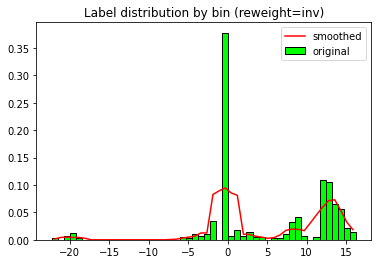

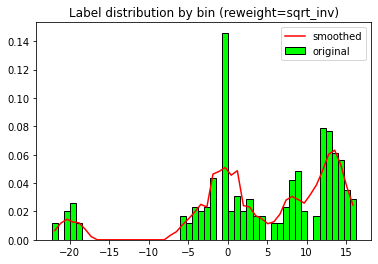

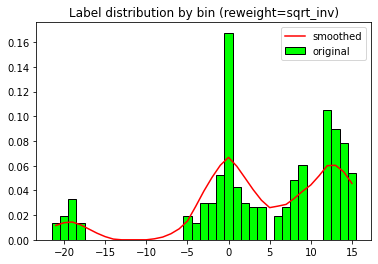

In [ ]:
labels = np.concatenate([np.random.normal(-20, 1, 10), np.random.normal(0, 2, 100), np.random.normal(12, 2, 300)], -1)
labels[(-1<labels) & (labels<1)] = 0   # This is done to create some 'gaps' for demo purposes
labels[(10<labels) & (labels<12)] = 0  # This is done to create some 'gaps' for demo purposes

n_bins = 50
label_range=None
reweight = 'inv'
lds_kernel='gaussian'
lds_ks=5
lds_sigma=2

weights_per_sample = prepare_LDS_weights(labels, n_bins, label_range=label_range, reweight=reweight, 
                                         lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma, show_plot=True)

n_bins = 50
label_range=None
reweight = 'sqrt_inv'
lds_kernel='gaussian'
lds_ks=5
lds_sigma=2

weights_per_sample = prepare_LDS_weights(labels, n_bins, label_range=label_range, reweight=reweight, 
                                         lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma, show_plot=True)

n_bins = None
label_range=None
reweight = 'sqrt_inv'
lds_kernel='triang'
lds_ks=9
lds_sigma=1

weights_per_sample = prepare_LDS_weights(labels, n_bins, label_range=label_range, reweight=reweight, 
                                         lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma, show_plot=True)

This loss will allow you to pass a different weight per individual sample.

In [ ]:
# export
class WeightedPerSampleLoss(Callback):
    order = 65

    r"""Loss wrapper than applies a weight per sample during training

    Weights are not applied to the validation loss.

    Args:
        instance_weights:   weights that will be applied. Weights will be normalized to 1.
                            You can pass weights for the entire dataset or just for the training set.
    """

    def __init__(self, instance_weights):
        store_attr()

    def before_fit(self):
        self.old_loss = self.learn.loss_func
        self.reduction = getattr(self.learn.loss_func, 'reduction', None)
        self.learn.loss_func = _PerInstanceLoss(crit=self.learn.loss_func)
        if len(self.instance_weights) == len(self.learn.dls.train.dataset):
            self.instance_weights = torch.cat([self.instance_weights, torch.zeros(len(self.learn.dls.valid.dataset))])
        assert len(self.instance_weights) == len(self.learn.dls.train.dataset) + len(self.learn.dls.valid.dataset)
        self.instance_weights = self.instance_weights / torch.sum(self.instance_weights) * len(self.instance_weights)
        self.instance_weights = torch.as_tensor(self.instance_weights, device=self.learn.dls.device)

    def before_batch(self):
        self.learn.loss_func.training = self.training
        if self.training:
            input_idxs = self.learn.dls.train.input_idxs
            self.learn.loss_func.weights = self.instance_weights[input_idxs]

    def after_fit(self):
        self.learn.loss_func = self.old_loss
        if self.reduction is not None: self.learn.loss_func.reduction = self.reduction
            

class _PerInstanceLoss(Module):
    def __init__(self, crit):
        self.crit = crit
        self.crit.reduction = 'none'
        self.weights = None
        self.training = False

    def forward(self, input, target):
        if not self.training:
            return self.crit(input, target).mean()
        else:
            return ((self.crit(input, target) * self.weights)).mean()

# BatchSubsampler

In [ ]:
# export

class BatchSubsampler(Callback):
    """ Callback that selects a percentage of samples and/ or sequence steps with replacement from each training batch

    Args:
    ====

    sample_pct:     percentage of random samples (or instances) that will be drawn. If 1. the output batch will contain the same number of samples
                    as the input batch.
    step_pct:       percentage of random sequence steps that will be drawn. If 1. the output batch will contain the same number of sequence steps
                    as the input batch. If used with models that don't use a pooling layer, this must be set to 1 to keep the same dimensions.
                    With CNNs, this value may be different.
    same_seq_len:   If True, it ensures that the output has the same shape as the input, even if the step_pct chosen is < 1. Defaults to True.
    update_y:       used with step_pct. If True, it applies the same random indices to y. It can only be used with sequential targets.
    """

    def __init__(self, sample_pct:Optional[float]=None, step_pct:Optional[float]=None, same_seq_len:bool=True, update_y:bool=False):
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return

    def before_batch(self):
        if not self.training: return

        if self.sample_pct is not None:
            B = self.x.shape[0]
            if isinstance(self.sample_pct, tuple):
                sample_pct = np.random.rand() * (self.sample_pct[1] - self.sample_pct[0]) + self.sample_pct[0]
            else:
                sample_pct = self.sample_pct
            idxs = np.random.choice(B, round(B * sample_pct), True)
            self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)
            self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)

        if self.step_pct is not None:
            S = self.x.shape[-1]
            if isinstance(self.step_pct, tuple):
                step_pct = np.random.rand() * (self.step_pct[1] - self.step_pct[0]) + self.step_pct[0]
            else:
                step_pct = self.step_pct
            if self.step_pct != 1 and self.same_seq_len:
                idxs = np.sort(np.tile(np.random.choice(S, round(S * step_pct), True), math.ceil(1 / step_pct))[:S])
            else:
                idxs = np.sort(np.random.choice(S, round(S * step_pct), True))
            self.learn.xb = tuple(xbi[...,idxs] for xbi in self.learn.xb)
            if self.update_y:
                self.learn.yb = tuple(ybi[...,idxs] for ybi in self.learn.yb)

# BatchLossFilter

In [ ]:
#export
class BatchLossFilter(Callback):
    """ Callback that selects the hardest samples in every batch representing a percentage of the total loss"""

    def __init__(self, loss_perc=1., schedule_func:Optional[callable]=None):
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return
        self.crit = self.learn.loss_func
        if hasattr(self.crit, 'reduction'): self.red = self.crit.reduction

    def before_batch(self):
        if not self.training: return
        if self.schedule_func is None: loss_perc = self.loss_perc
        else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)
        if loss_perc == 1.: return
        with torch.no_grad():
            if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', 'none')
            losses = self.crit(self.learn.model(self.x), self.y)
            if losses.ndim == 2: losses = losses.mean(-1)
            if hasattr(self.crit, 'reduction'):  setattr(self.crit, 'reduction', self.red)
            losses /= losses.sum()
            idxs = torch.argsort(losses, descending=True)
            cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))
            idxs = idxs[:cut_idx]
            self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)
            self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)

    def after_fit(self):
        if hasattr(self.learn.loss_func, 'reduction'):  setattr(self.learn.loss_func, 'reduction', self.red)

# RandomWeightLossWrapper

In [ ]:
# export

class RandomWeightLossWrapper(Callback):

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return
        self.crit = self.learn.loss_func
        if hasattr(self.crit, 'reduction'): self.red = self.crit.reduction
        self.learn.loss_func = self._random_weight_loss

    def _random_weight_loss(self, input: Tensor, target: Tensor) -> Tensor:
        if self.training:
            setattr(self.crit, 'reduction', 'none')
            loss = self.crit(input, target)
            setattr(self.crit, 'reduction', self.red)
            rw = torch.rand(input.shape[0], device=input.device)
            rw /= rw.sum()
            non_red_loss = loss * rw
            return non_red_loss.sum()
        else:
            return self.crit(input, target)

    def after_fit(self):
        if hasattr(self.crit, 'reduction'): setattr(self.crit, 'reduction', self.red)
        self.learn.loss_func = self.crit

# SamplerWithReplacement

In [ ]:
# export

class SamplerWithReplacement(Callback):
    """ Callback that selects a percentage of samples and/ or sequence steps with replacement from each training batch"""

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return

        self.old_get_idxs = self.learn.dls.train.get_idxs
        self.learn.dls.train.get_idxs = self._get_idxs

    def _get_idxs(self):
        dl = self.learn.dls.train
        if dl.n==0: return []
        if dl.weights is not None:
            return np.random.choice(dl.n, dl.n, p=dl.weights)
        idxs = Inf.count if dl.indexed else Inf.nones
        if dl.n is not None: idxs = np.random.choice(dl.n,dl.n,True)
        if dl.shuffle: idxs = dl.shuffle_fn(idxs)
        return idxs

    def after_fit(self):
        self.learn.dls.train.get_idxs = self.old_get_idxs

# BatchMasker

In [ ]:
# export

class BatchMasker(Callback):
    """ Callback that applies a random mask to each sample in a training batch

    Args:
    ====
    r:                  probability of masking.
    subsequence_mask:   apply a mask to random subsequences.
    lm:                 average mask len when using stateful (geometric) masking.
    stateful:           geometric distribution is applied so that average mask length is lm.
    sync:               all variables have the same masking.
    variable_mask:      apply a mask to random variables. Only applicable to multivariate time series.
    future_mask:        used to train a forecasting model.
    schedule_func:      if a scheduler is passed, it will modify the probability of masking during training.
    """

    def __init__(self, r:float=.15, lm:int=3, stateful:bool=True, sync:bool=False, subsequence_mask:bool=True, 
                 variable_mask:bool=False, future_mask:bool=False, schedule_func:Optional[callable]=None):
        store_attr()

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return

    def before_batch(self):
        if not self.training: return
        r = self.r * self.schedule_func(self.pct_train) if self.schedule_func is not None else self.r
        mask = create_mask(self.x,  r=r, lm=self.lm, stateful=self.stateful, sync=self.sync, 
                        subsequence_mask=self.subsequence_mask, variable_mask=self.variable_mask, future_mask=self.future_mask)
        self.learn.xb = (self.xb[0].masked_fill(mask, 0),)
        # In my tests, mask-based compensation doesn't seem to be important. ??
        # mean_per_seq = (torch.max(torch.ones(1, device=mask.device), torch.sum(mask, dim=-1).unsqueeze(-1)) / mask.shape[-1])
        # self.learn.xb = (self.xb[0].masked_fill(mask, 0) / (1 - mean_per_seq), )

# SamplerWithReplacement

In [ ]:
# export

class SamplerWithReplacement(Callback):
    """ Callback that modify the sampler to select a percentage of samples and/ or sequence steps with replacement from each training batch"""

    def before_fit(self):
        self.run = not hasattr(self, "gather_preds")
        if not(self.run): return

        self.old_get_idxs = self.learn.dls.train.get_idxs
        self.learn.dls.train.get_idxs = self._get_idxs

    def _get_idxs(self):
        dl = self.learn.dls.train
        if dl.n==0: return []
        if dl.weights is not None:
            return np.random.choice(dl.n, dl.n, p=dl.weights)
        idxs = Inf.count if dl.indexed else Inf.nones
        if dl.n is not None: idxs = np.random.choice(dl.n,dl.n,True)
        if dl.shuffle: idxs = dl.shuffle_fn(idxs)
        return idxs

    def after_fit(self):
        self.learn.dls.train.get_idxs = self.old_get_idxs

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);

<IPython.core.display.Javascript object>

060_callback.core.ipynb saved at 2021-12-28 13:46:36.
Converted 060_callback.core.ipynb.


Correct conversion! 😃
Total time elapsed 0.095 s
Tuesday 28/12/21 13:46:39 CET
